Test error analysis

จะมาเปรียบเทียบว่าได้คะเเนนในเเต่ละส่วนเท่าไหร่

In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
import json

# 🔍 ชี้ path ตรงไปยังตำแหน่งไฟล์บน Google Drive
ground_truth_path = "/content/drive/MyDrive/LockLearn/evaluation_datasetv2.json"
rag_results_path = "/content/drive/MyDrive/LockLearn/evaluation_rag_results_v2_BGE_M3_K=10.json"

# 🔄 โหลดข้อมูลจากไฟล์ JSON
with open(ground_truth_path, "r", encoding="utf-8") as f:
    ground_truth_data = json.load(f)

with open(rag_results_path, "r", encoding="utf-8") as f:
    rag_results_data = json.load(f)

print(f"✅ จำนวนตัวอย่างใน ground truth: {len(ground_truth_data)}")
print(f"✅ จำนวนตัวอย่างใน RAG results: {len(rag_results_data)}")


In [2]:
import json
import csv
from difflib import SequenceMatcher
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# ระบุ path ของไฟล์ใน Google Drive
ground_truth_path = '/content/drive/MyDrive/LockLearn/evaluation_datasetv2.json'
rag_results_path = '/content/drive/MyDrive/LockLearn/evaluation_rag_results_v2_BGE_M3_K=10.json'
output_csv_path = '/content/drive/MyDrive/LockLearn/rag_error_analysis.csv'

# โหลดไฟล์ JSON
with open(ground_truth_path, 'r', encoding='utf-8') as f:
    ground_truth = json.load(f)

with open(rag_results_path, 'r', encoding='utf-8') as f:
    rag_results = json.load(f)

# ตรวจสอบว่าเป็น 1:1 mapping
assert len(ground_truth) == len(rag_results)

# สร้างไฟล์ CSV สำหรับวิเคราะห์ข้อผิดพลาด
with open(output_csv_path, 'w', encoding='utf-8', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow([
        'Index', 'Question', 'Ground Truth Answer', 'RAG Recommendations',
        'Any Match?', 'Max Similarity to Ground Truth', 'Error Type'
    ])

    for i, (gt, rag) in enumerate(zip(ground_truth, rag_results), 1):
        question = gt['question']
        ground_truth_answer = gt['answer']
        recommendations = rag['recommendations']

        # ตรวจว่ามีคำแนะนำที่ตรงกับคำตอบจริงหรือไม่
        matches = [rec for rec in recommendations if rec.strip() == ground_truth_answer.strip()]

        # คำนวณ similarity
        similarities = [SequenceMatcher(None, ground_truth_answer, rec).ratio() for rec in recommendations]
        max_sim = max(similarities) if similarities else 0.0

        # ประเภทของข้อผิดพลาด
        if matches:
            error_type = '✅ Exact Match'
        elif max_sim >= 0.7:
            error_type = '🟡 Similar Meaning'
        elif max_sim >= 0.4:
            error_type = '🔸 Weakly Related'
        else:
            error_type = '❌ Irrelevant'

        writer.writerow([
            i,
            question,
            ground_truth_answer,
            " | ".join(recommendations),
            'Yes' if matches else 'No',
            f"{max_sim:.2f}",
            error_type
        ])

print("✅ Error analysis saved to:", output_csv_path)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Error analysis saved to: /content/drive/MyDrive/LockLearn/rag_error_analysis.csv


In [3]:
from collections import Counter

error_types = []

for gt, rag in zip(ground_truth, rag_results):
    ground_truth_answer = gt['answer']
    recommendations = rag['recommendations']
    matches = [rec for rec in recommendations if rec.strip() == ground_truth_answer.strip()]
    similarities = [SequenceMatcher(None, ground_truth_answer, rec).ratio() for rec in recommendations]
    max_sim = max(similarities) if similarities else 0.0

    if matches:
        error_type = 'Exact Match'
    elif max_sim >= 0.7:
        error_type = 'Similar Meaning'
    elif max_sim >= 0.4:
        error_type = 'Weakly Related'
    else:
        error_type = 'Irrelevant'

    error_types.append(error_type)

summary = Counter(error_types)
print("📊 Error Type Summary:")
for etype, count in summary.items():
    print(f"{etype}: {count} ({count / len(ground_truth):.2%})")


📊 Error Type Summary:
Weakly Related: 256 (18.69%)
Exact Match: 923 (67.37%)
Irrelevant: 190 (13.87%)
Similar Meaning: 1 (0.07%)


ต่อมาเราจะดูข้อมูลเชิงลึกโดยใช้ข้อมูลจากที่ LLM judge มาเพื่อมาดูข้อผิดพลาด

In [5]:
import json
import re

judgement_file = '/content/drive/MyDrive/LockLearn/llm_judgement_scores2.json'

# โหลดข้อมูล
with open(judgement_file, 'r', encoding='utf-8') as f:
    data = json.load(f)

# เตรียม pattern สำหรับจับคะแนน
score_pattern = re.compile(r"\b([1-5])\b")


In [6]:
low_score_items = []

for item in data:
    match = score_pattern.search(item['evaluation'])
    if match:
        score = int(match.group(1))
        if score <= 3:
            item['score'] = score
            low_score_items.append(item)

print(f"จำนวนคำตอบที่ได้คะแนน 1–3: {len(low_score_items)}")


จำนวนคำตอบที่ได้คะแนน 1–3: 224


In [9]:
def classify_error(evaluation_text):
    text = evaluation_text.lower()
    if "off-topic" in text or "not address" in text or "miss the point" in text:
        return "Off-topic"
    elif "incorrect" in text or "wrong" in text or "factually" in text:
        return "Incorrect Info"
    elif "not supportive" in text or "lack of encouragement" in text or "no motivation" in text:
        return "Missing Encouragement"
    elif "tone" in text or "harsh" in text or "unfriendly" in text:
        return "Harsh Tone"
    elif "incomplete" in text or "missing details" in text or "not enough info" in text or "lacks depth" in text:
        return "Incomplete"
    elif "generic" in text or "vague" in text:
        return "Too Generic"
    else:
        return "Other"


🔢 จำนวนข้อผิดพลาดแต่ละประเภท (คะแนน 1–3):
Other: 189
Harsh Tone: 33
Incomplete: 1
Incorrect Info: 1


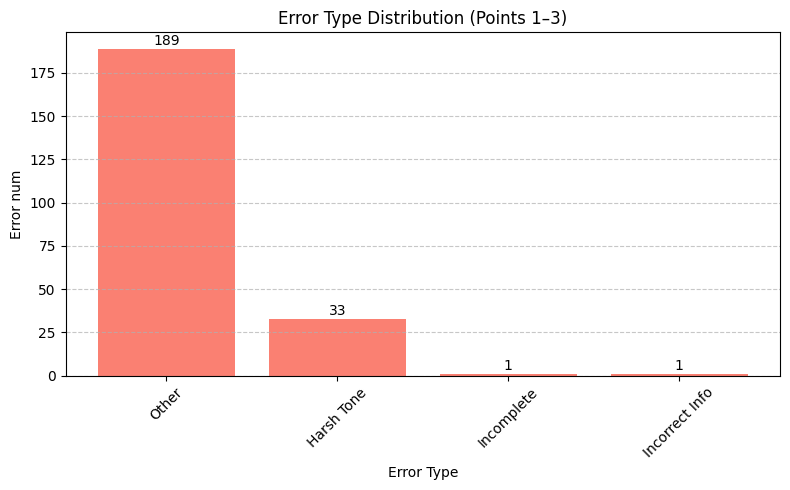

In [14]:
import collections
import matplotlib.pyplot as plt

# นับจำนวนแต่ละ error type
error_counts = collections.Counter([item['error_type'] for item in low_score_items])

# แสดงจำนวนแต่ละ error type ใน console
print("🔢 จำนวนข้อผิดพลาดแต่ละประเภท (คะแนน 1–3):")
for err_type, count in error_counts.items():
    print(f"{err_type}: {count}")

# พล็อตกราฟ
plt.figure(figsize=(8, 5))
bars = plt.bar(error_counts.keys(), error_counts.values(), color='salmon')

# เพิ่มจำนวนบนแท่งกราฟ
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 0.5, f'{int(height)}',
             ha='center', va='bottom', fontsize=10)

plt.xlabel("Error Type")
plt.ylabel("Error num")
plt.title("Error Type Distribution (Points 1–3)")
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


In [11]:
print("\n🔎 ตัวอย่างที่เข้า Other:")
for i, item in enumerate(low_score_items):
    if item['error_type'] == 'Other':
        print(f"\nExample {i+1}")
        print("📌 Question:", item['question'])
        print("🤖 Evaluation:", item['evaluation'])
        if i >= 5:  # ดูแค่ 5 อันพอ
            break



🔎 ตัวอย่างที่เข้า Other:

Example 1
📌 Question: How can I apply the principles of lasting change to different areas of my life, and what would be the potential impact on my personal growth, career, and the world around me?
🤖 Evaluation: I would give the LLM-generated answer a score of 3. The answer is somewhat relevant but misses the key point of specifically applying the principles of lasting change to different areas of life, instead focusing on general personal growth and transformation.

Example 2
📌 Question: What if I made a promise to myself when I was younger, but now that I'm older, my priorities have completely changed - do I still owe it to myself to follow through on that old commitment, or is it okay to let it go?
🤖 Evaluation: I would give the LLM-generated answer a score of 2. The answer acknowledges the importance of self-commitments but deviates from the ground truth by suggesting it's okay to let go of old promises, whereas the ground truth emphasizes following throug